In [117]:
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, "../")

from PDE_search import build_custom_Theta, BruteForceL0, TotalFiniteDiff_t, TotalFiniteDiff, build_Theta,\
TrainSTRidge, print_pde, build_linear_system, STRidgeScan

from scipy.signal import savgol_filter
from utils import scalar_pde_solver, save_dict, load_dict, get_u_term_from_descr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# In this example we consider evolution of a single magnon initial state in a ferromagnetic XXZ spin chain.
The Hamiltonian of the model reads:
$$ H = \sum_i \left[ J(S^{x}_i S^{x}_{i+1} + S^y_{i} S^y_{i+1})+\Delta S^z_i S^z_{i+1} \right] + \sum_i B_i S^z_i$$
We prepare the initial state as a wave packet given by a superposition of the product state and a single spin flip: $$|\psi_0\rangle  = \sum_{n}  f(n) |+\rangle_{n} \prod_{j \neq n} |\downarrow\rangle_{j} = \frac {1}{\sqrt{\pi\sigma^2}} \sum_{n} e^{-(n - x_0)^2/\sigma^2} | + \rangle_n \prod_{j \neq n} |\downarrow\rangle_{j}.$$

Here $f(n)$ is the Gaussian envelope function.

We introduce the following complex-valued function $u(t, x)$. At the sites of the spin chain, $x_i \equiv i a$, where $a$ is the lattice spacing, we set  the value of the function to
\begin{equation}
u(t, x_i) = \langle S^+_i(t) \rangle = \frac{1}{2}[\langle \sigma^x_i(t)\rangle + i\langle \sigma^y_i(t)\rangle],
\end{equation}
where $S^+_i=S^x_i+iS^y_i = \frac{1}{2} (\sigma^x_i + i \sigma^y_i)$ is the spin raising operator, $O(t) = \exp{(iHt)}O\exp{(-iHt)}$ is the time-dependent operator in the Heisenberg picture, and $\langle O \rangle \equiv \langle\psi_0|O|\psi_0\rangle$ is the expectation value taken in the initial state.

One can show that the dynamics of the complex field $u(t,x)$ is described by the following self-contained PDE:
$$i \partial_t u = J\cos{(i\partial_x)}u-\Delta u - B(x) u.$$
Assuming that the we assume that the magnetic field and the observables of the spin system change slowly, we arrive to the hydrodynamic-type PDE
$$
i\partial_t u =\frac{J}{2} \partial^2_x u + (J-\Delta) u - B(x) u + \mathcal{O(\partial_x^4 u)}.
$$

## Now we will "learn" the evolution PDE directly from data

In [88]:
dict_data = load_dict('./data/single_magnon.npy')

stop = 500

u = dict_data['u'][:stop]
x = dict_data['x']
t = dict_data['t'][:stop]

## Visualize data

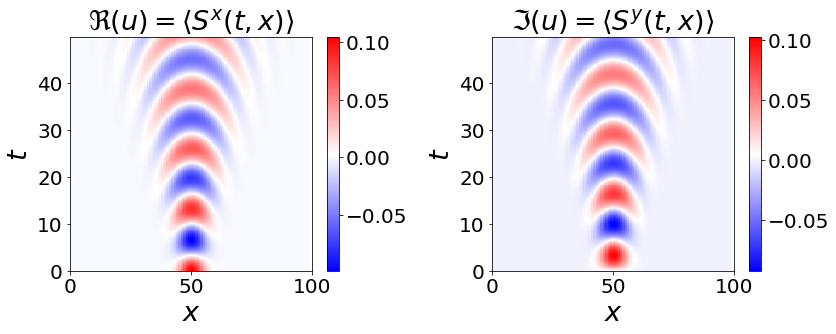

In [89]:
xx, tt = np.meshgrid(x, t)
fig, ax = plt.subplots(1, 2, figsize = (12, 5));
plt_re = ax[0].pcolormesh(xx, tt, u.real, cmap='bwr', rasterized=True)
ax[0].set_title(r"$ \Re(u) = \langle S^x(t,x) \rangle$" )
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$t$")
ax[0].set_xticks([0,50,100])
plt.colorbar(plt_re, ax=ax[0])             

plt_im = ax[1].pcolormesh(xx, tt, u.imag, cmap='bwr', rasterized=True)
ax[1].set_title(r"$ \Im(u) = \langle S^y(t,x) \rangle$" )
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$t$")
ax[1].set_xticks([0,50,100])
plt.colorbar(plt_im, ax=ax[1])    
fig.tight_layout(pad=2.0)

### Dataset dimensions

In [90]:
dt = t[1]-t[0]
dx = x[1]-x[0]
m, n = u.shape

print('dt: ', dt, 'dx: ', dx)
print('Dataset dimensions: ', u.shape)
print('Xmax, Tmax: ', x[-1], t[-1])

dt:  0.1001001001001001 dx:  1
Dataset dimensions:  (500, 100)
Xmax, Tmax:  99 49.94994994994995


# Recovering PDE for $u(t, x)$

### Fourier method for calculation of spatial derivatives

In [105]:
bc = "periodic"
# Compute temporal derivative u_t from the data
ut = TotalFiniteDiff_t(u, dt).reshape((n*m,1))

# Define a list of candidate terms
descr = [  
           'u',
           'u_x',
           'u_x^2',
           'u*u_x', 
           'u^2*u_x', 
           'u^3*u_x',
           'u^4*u_x', 
           'u^5*u_x', 
           'u_xx', 
           'u_xxx', 
           'u_xxxx',
           'u*u_xx',
           'u^2*u_xx',
        ]

u_data = []
for term in descr:
    u_data.append(get_u_term_from_descr(term, u, x, bc, deriv="Fourier").reshape((n*m,1)))

u_data = np.hstack(u_data)
Theta, descr = build_custom_Theta(u_data, descr)

In [106]:
print(f'Considering {len(descr)} candidate terms {descr}')

Considering 10 candidate terms ['u', 'u_x', 'u_x^2', 'u*u_x', 'u^2*u_x', 'u^3*u_x', 'u^4*u_x', 'u^5*u_x', 'u_xx', 'u_xxxx']


## Now we are ready to perform PDE-learning

In [109]:
xi, _ = BruteForceL0(Theta, ut, descr, l0_penalty=1e-3, verbose=False)

Best PDE found with BruteForce:
u_t = (-0.000001 +0.499600i)u
    + (0.000017 +0.489594i)u_xx
   
Time elapsed (s): 2.3435070514678955


The inferred PDE matches theoretically expected equation:
$$i\partial_t u = -\frac{1}{2} \partial^2_x u - \frac{1}{2}u + \mathcal{O(\partial_x^4 u)}$$
for $J = -1$, $\Delta=-0.5$. 

Lets decrease the L0 penalty constant

In [110]:
xi, _ = BruteForceL0(Theta, ut, descr, l0_penalty=1e-6, verbose=False)

Best PDE found with BruteForce:
u_t = (-0.000000 +0.499793i)u
    + (-0.000000 +0.499301i)u_xx
    + (-0.000001 +0.040329i)u_xxxx
   
Time elapsed (s): 5.337058067321777


We discovered correction terms containing the fourth spatial derivative!
$$i\partial_t u = -\frac{1}{2} \partial^2_x u - \frac{1}{24} \partial_x^4 u - \frac{1}{2}u + \mathcal{O(\partial_x^6 u)}$$

## Now we are comparing solution of the inferred PDE with the data

In [113]:
# Define the initial condition
u0 = u[0]
# parameter num_integrator_steps corresponds to the number of Euler integrator steps between t and t+dt
u_ev = scalar_pde_solver(descr, xi, u0, t, x, 
                  bc="periodic", num_integrator_steps=100)

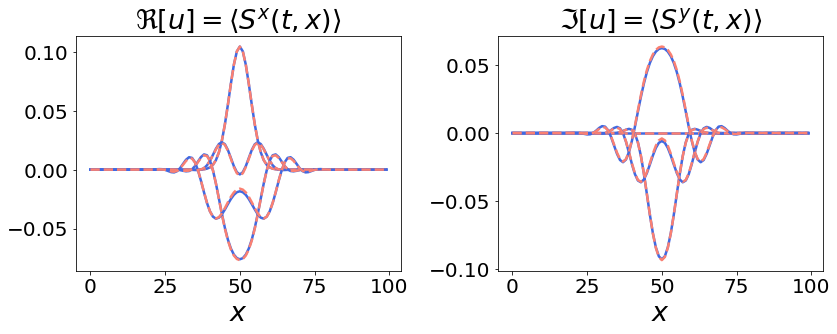

In [115]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5));
for it in np.arange(0, 400, 100):
    ax[0].plot(u[it, :].real, c='royalblue')
    ax[0].plot(u_ev[it, :].real, ls='--', c='salmon')
    ax[0].set_xlabel(r'$x$')
    ax[0].set_title(r'$\Re[u]=\langle S^x (t,x) \rangle$')
    
    ax[1].plot(u[it, :].imag, c='royalblue')
    ax[1].plot(u_ev[it, :].imag, ls='--', c='salmon')
    ax[1].set_xlabel(r'$x$')
    ax[1].set_title(r'$\Im[u]=\langle S^y (t,x) \rangle$')

fig.tight_layout(pad=2.0)

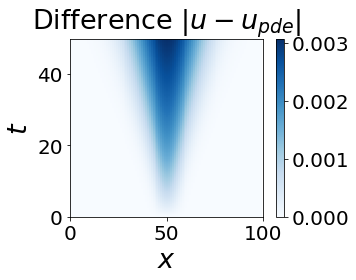

In [100]:
plt.pcolormesh(xx, tt, abs(u-u_ev), cmap='Blues', rasterized=True)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Difference $|u-u_{pde}|$')
plt.xticks([0,50,100])
plt.tight_layout()

### Plot Pareto frontier of inferred PDEs: scanning across the values of $\lambda_0$ penalty parameter

In [138]:
# Use heuristic STRidge algorithm for faster performance
results_pareto = STRidgeScan(Theta, ut, descr, lam_l2=0, l0_fin=1, num_points=10, verbose=False)

Below we are reconstructing the PDE for various values of $\lambda_0$:

In [139]:
for i, data in enumerate(results_pareto['train_data']):
    print('L0 penalty', results_pareto['l0_arr'][i])
    print_pde(data['best_xi'], descr)

L0 penalty 1e-08
u_t = (0.000000 +0.499793i)u
    + (-0.000186 +0.000501i)u_x^2
    + (0.000000 +0.499302i)u_xx
    + (-0.000002 +0.040337i)u_xxxx
   
L0 penalty 7.742636826811277e-08
u_t = (-0.000000 +0.499793i)u
    + (0.000000 +0.499302i)u_xx
    + (-0.000000 +0.040339i)u_xxxx
   
L0 penalty 5.994842503189409e-07
u_t = (-0.000000 +0.499793i)u
    + (0.000000 +0.499302i)u_xx
    + (-0.000000 +0.040339i)u_xxxx
   
L0 penalty 4.641588833612773e-06
u_t = (-0.000000 +0.499793i)u
    + (0.000000 +0.499302i)u_xx
    + (-0.000000 +0.040339i)u_xxxx
   
L0 penalty 3.5938136638046256e-05
u_t = (-0.000000 +0.499793i)u
    + (0.000000 +0.499302i)u_xx
    + (-0.000000 +0.040339i)u_xxxx
   
L0 penalty 0.0002782559402207126
u_t = (-0.000000 +0.499793i)u
    + (0.000000 +0.499302i)u_xx
    + (-0.000000 +0.040339i)u_xxxx
   
L0 penalty 0.002154434690031882
u_t = (-0.000000 +0.499599i)u
    + (0.000000 +0.489621i)u_xx
   
L0 penalty 0.016681005372000558
u_t = (-0.000000 +0.499599i)u
    + (0.000000 +0

For very small penalty parameter $\lambda=10^{-8}$ the recovered PDE contains a spurious term ($u_x^2$), which is the overfitting regime. For intermediate values of the penlty parameter $\lambda_0\in [10^{-7}, 10^{-2}]$ we find the correct PDEs matching Tailor expansion of the exact equation $$i \partial_t u = J\cos{(i\partial_x)}u-\Delta u.$$
Meanwhile for large values of the penalty coefficient $\lambda_0=1$ we enter the underfit region, where the inferred PDE misses gradient terms.

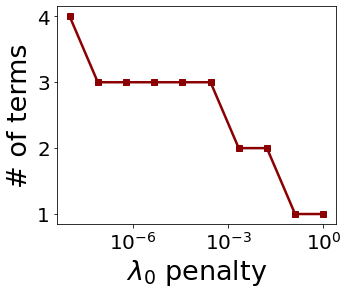

In [140]:
num_terms = [np.count_nonzero(data['best_xi']) for data in results_pareto['train_data']]
l0_arr = results_ridge['l0_arr']
plt.plot(l0_arr, num_terms, marker='s', c='darkred')
plt.xscale('log')
plt.xlabel(r'$\lambda_0$ penalty')
plt.ylabel('# of terms');